# Notebook 4 - Modeling

This notebook will perform the splitting of data, training and testing the selected models, and identifying the final model to be selected.

In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval
from scipy import sparse
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
import pickle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform

In [3]:
#import data
# Read in preprocessed data
preproc_df = pd.read_csv("data/genre_prepped.csv.gz", compression = "gzip",
                         converters = {"tokens": literal_eval, "genre" : literal_eval})

# drop unnecessary columns (index and unnamed index columns)
preproc_df = preproc_df.drop(preproc_df.columns[0:2], axis = 1)

# Sample Table
preproc_df.head(5)

,artist,title,lyrics,genre,tokens,lyrics_clean
0,Taylor Swift,​betty,"Betty, I won't make assumptions\nAbout why you...",[country],"[betty, make, assumptions, switched, homeroom,...",betty make assumptions switched homeroom think...
1,John Denver,"Take Me Home, Country Roads","Almost Heaven, West Virginia\nBlue Ridge Mount...",[country],"[almost, heaven, west, virginia, blue, ridge, ...",almost heaven west virginia blue ridge mountai...
2,Post Malone,Feeling Whitney,"I've been looking for someone...\nOoh, ooh, oo...",[country],"[looking, someone, ooh, ooh, ooh, ooh, ooh, oo...",looking someone ooh ooh ooh ooh ooh oohooh ooh...
3,Cam,Burning House,\n[Verse 1]\nI had a dream about a burning hou...,[country],"[dream, burning, house, stuck, inside, get, la...",dream burning house stuck inside get laid besi...
4,Johnny Cash,Folsom Prison Blues,"I hear the train a-comin', it's rolling 'round...",[country],"[hear, train, acomin, rolling, round, bend, ai...",hear train acomin rolling round bend aint seen...


# Format the labels

In [4]:
# Convert genres to set for multilabel encoding
preproc_df["genre_set"] = preproc_df["genre"].map(set)

In [5]:
mlb = MultiLabelBinarizer()
genre_array = mlb.fit_transform(preproc_df["genre_set"])
genre_array

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [6]:
# Convert label array to sparse matrix
genre_sparse = sparse.csr_matrix(genre_array)

# Vectorize text input
We'll use TF-IDF vectors for now

In [7]:
tfidf_vectorizer = TfidfVectorizer()
text_sparse = tfidf_vectorizer.fit_transform(preproc_df['lyrics_clean'])

# Splitting the data into training and testing
Using 70/30 train/test split.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(text_sparse, genre_array,
                                                    test_size= 0.3 , random_state= 2023)

# Models 

For classification, the selected models will demonstrate the commonly used for text classification: K-Nearest Neighbors

### Create custom scorer: 
Hamming loss will take into account the fraction of each prediction that is right over accuracy which evaluates exact matches.

In [9]:
hamming_loss_scorer = make_scorer(hamming_loss)

### KNN Model
Train

In [41]:
# Set up hyperparameter options
n_neighbors = range(1,21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'minkowski'] # Manhattan was failing to fit - these two should work alright though

# Setup model pipeline so we can reference it in param_distributions
knn_pipe = Pipeline(
    steps = [
        ('knn', MultiOutputClassifier(KNeighborsClassifier(), n_jobs= - 1))
    ]
)

# Search
knn_tuned = GridSearchCV(
    estimator= knn_pipe,
    param_grid = {'knn__estimator__n_neighbors' : n_neighbors,
                   'knn__estimator__weights' : weights,
                   'knn__estimator__metric' : metric},
    scoring= 'f1_macro'
).fit(X_train, y_train)

# Return the best model parameters
knn_tuned.best_params_

{'knn__estimator__metric': 'euclidean',
 'knn__estimator__n_neighbors': 1,
 'knn__estimator__weights': 'uniform'}

Save so we don't need to retrain in the future

In [42]:
pickle.dump(knn_tuned, open('models/knn_tuned.sav', 'wb'))

### Support Vector Classification Model

In [43]:
# Set up hyperparameter options - we'll use two sub dictionaries to avoid using degree with non-poly kernels
param_grid_svc = [
    {'svc__estimator__kernel': ['linear', 'rbf', 'sigmoid'],
     'svc__estimator__C': [0.1, 1, 10, 100],
     'svc__estimator__gamma': [1, 0.1, 0.01, 0.001]},

    {'svc__estimator__kernel' : ['poly'],
     'svc__estimator__C': [0.1, 1, 10, 100],
     'svc__estimator__gamma': [1, 0.1, 0.01, 0.001],
     'svc__estimator__degree': [2,3,4,5]}
]

# Setup model pipeline so we can reference it in param_distributions
svc_pipe = Pipeline(
    steps = [
        ('svc', MultiOutputClassifier(SVC(), n_jobs= - 1))
    ]
)

# Search
svc_tuned = GridSearchCV(
    estimator= svc_pipe,
    param_grid = param_grid_svc,
    scoring= 'f1_macro'
    ).fit(X_train, y_train)

# Return the best model parameters
svc_tuned.best_params_

{'svc__estimator__C': 10,
 'svc__estimator__gamma': 1,
 'svc__estimator__kernel': 'sigmoid'}

In [ ]:
# Whoops
svc_tuned = MultiOutputClassifier(SVC(C = 10, gamma = 1, kernel = 'sigmoid'))

In [44]:
pickle.dump(svc_tuned, open('models/svc_tuned.sav', 'wb'))

### Naive Bayes Model

In [45]:
# Set up hyperparameter options
param_grid_nb = {'nb__estimator__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Setup model pipeline so we can reference it in param_distributions
nb_pipe = Pipeline(
    steps = [
        ('nb', MultiOutputClassifier(MultinomialNB(), n_jobs= - 1))
    ]
)

# Search
nb_tuned = GridSearchCV(
    estimator= nb_pipe,
    param_grid = param_grid_nb,
    scoring= 'f1_macro'
    ).fit(X_train, y_train)

# Return the best model parameters
nb_tuned.best_params_

{'nb__estimator__alpha': 0.01}

In [ ]:
# Whoops
nb_tuned = MultiOutputClassifier(MultinomialNB(alpha = 0.01))

In [46]:
# Save the model 
pickle.dump(nb_tuned, open('models/nb_tuned.sav', 'wb'))

### Gradient Boosted Classifier

In [61]:
# Set up hyperparameters
param_grid_gb = {
    "gb__estimator__n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    "gb__estimator__max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "gb__estimator__learning_rate": loguniform(0.01, 1),
    "gb__estimator__max_depth" : [2, 3, 4, 5, 6, 7]
}

# Setup model pipeline so we can reference it in param_distributions
gb_pipe = Pipeline(
    steps = [
        ('gb', MultiOutputClassifier(GradientBoostingClassifier(), n_jobs= - 1))
    ]
)

# Search
gb_tuned = RandomizedSearchCV(
    estimator= gb_pipe,
    param_distributions = param_grid_gb,
    scoring= 'f1_macro',
    n_iter= 100,
    random_state= 2023
    ).fit(X_train, y_train)

# Return the best model parameters
gb_tuned.best_params_

{'gb__estimator__learning_rate': 0.15105239751385705,
 'gb__estimator__max_depth': 6,
 'gb__estimator__max_leaf_nodes': 20,
 'gb__estimator__n_estimators': 500}

In [62]:
# Save the model
pickle.dump(gb_tuned, open('models/gb_tuned.sav', 'wb'))

# Model Results
Bring in our model and predict

In [63]:
# Load our models
knn_load = pickle.load(open('models/knn_tuned.sav', 'rb'))
svc_load = pickle.load(open('models/svc_tuned.sav', 'rb'))
nb_load = pickle.load(open('models/nb_tuned.sav', 'rb'))
gb_load = pickle.load(open('models/gb_tuned.sav', 'rb'))

# Predict the models
knn_pred = knn_load.predict(X_test)
svc_pred = svc_load.predict(X_test)
nb_pred = nb_load.predict(X_test)
gb_pred = gb_load.predict(X_test)

# Save models and names in list
model_preds = [knn_pred, svc_pred, nb_pred, gb_pred]
model_names = ['KNN', 'SVC', 'NB', 'GB']

FileNotFoundError: [Errno 2] No such file or directory: 'models/svc_tuned.sav'

A little info on Hamming Loss:

https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

In [ ]:
for pred, name in list(zip(model_preds, model_names)):
    ham_loss = hamming_loss(y_test, pred)
    print('Our Hamming Loss for the', name, 'model was', round(ham_loss, 2))

Our Hamming Loss for the KNN model was 0.31
Our Hamming Loss for the SVC model was 0.26
Our Hamming Loss for the NB model was 0.22


In [ ]:
# Get label names so report makes sense
label_names = mlb.classes_


# Set up empy results list
report_list = []

# Loop through models 

for pred, name in list(zip(model_preds, model_names)):
    
      report = classification_report(y_test, pred, target_names=label_names)
      report_dict = classification_report(y_test, pred, target_names=label_names, output_dict=True)

      # Put report in df for plot
      report_df_temp = pd.DataFrame(report_dict).transpose()

      # Clean up df
      report_df_temp['subset'] = report_df_temp.index
      report_df_temp['model'] = name

      report_list.append(report_df_temp)

      print('Classification Report for', name, 'model:\n\n', 
            report)

# Save our results to a df for plotting
report_df = pd.concat(report_list).reset_index(drop=True)

Classification Report for KNN model:

               precision    recall  f1-score   support

     country       0.36      0.38      0.37       284
         pop       0.31      0.29      0.30       302
         r-b       0.31      0.38      0.35       303
         rap       0.46      0.48      0.47       301
        rock       0.33      0.26      0.29       301

   micro avg       0.35      0.36      0.36      1491
   macro avg       0.35      0.36      0.35      1491
weighted avg       0.35      0.36      0.35      1491
 samples avg       0.36      0.36      0.35      1491

Classification Report for SVC model:

               precision    recall  f1-score   support

     country       0.52      0.46      0.49       284
         pop       0.32      0.28      0.30       302
         r-b       0.40      0.39      0.39       303
         rap       0.65      0.60      0.63       301
        rock       0.42      0.38      0.40       301

   micro avg       0.46      0.42      0.44      1491

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

In [ ]:
# Fucntion to plot multi-label confusion matrices
def plot_class_cms(y_pred, model_name):
    f, axes = plt.subplots(2, 3, figsize=(12, 9))
    axes = axes.ravel()
    for i in range(5):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                    y_pred[:, i]),
                                    display_labels=[0, i])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_xticklabels([0,1])
        disp.ax_.set_yticklabels([0,1])
        disp.ax_.set_title(label_names[i])

        # Put label on each new row
        if i%3!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    # Get rid of extra plot
    axes[5].set_axis_off()

    # Plot
    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    plt.suptitle('Confusion Matrix for Each Class: ' + model_name)
    f.colorbar(disp.im_, ax=axes)
    plt.show()


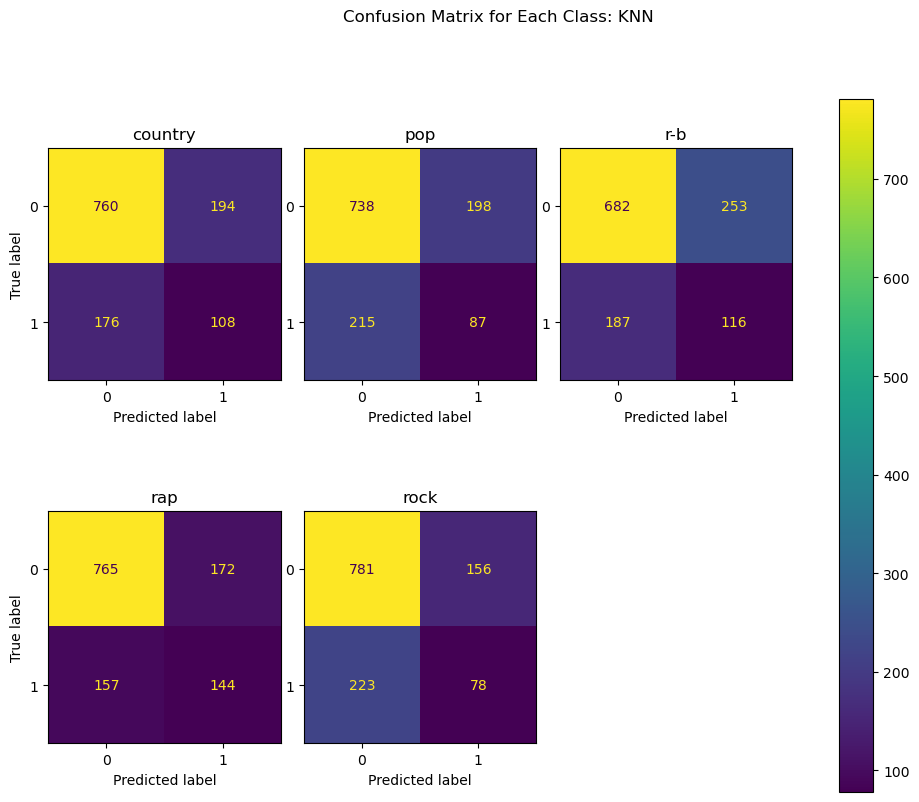

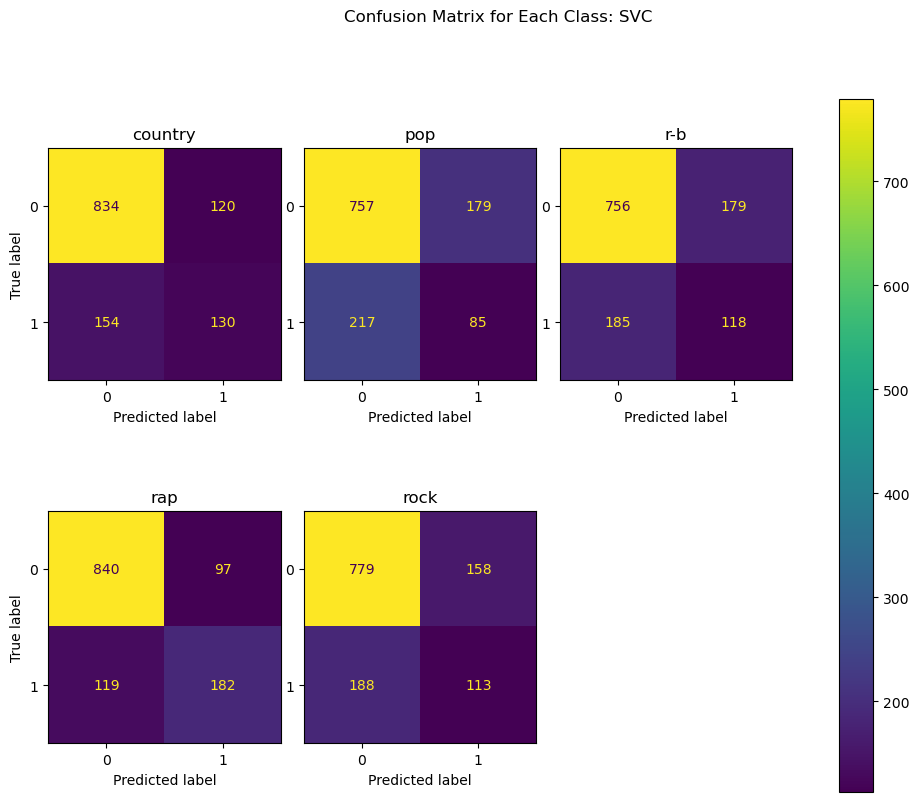

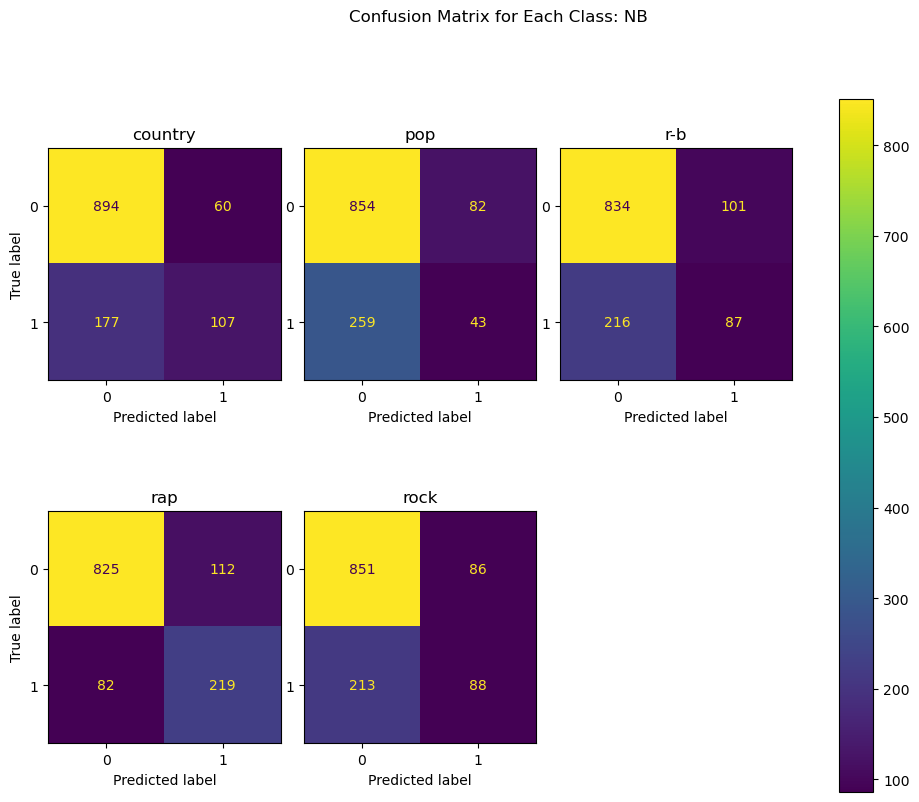

In [ ]:
for pred, name in list(zip(model_preds, model_names)):
    plot_class_cms(y_pred=pred, model_name=name)

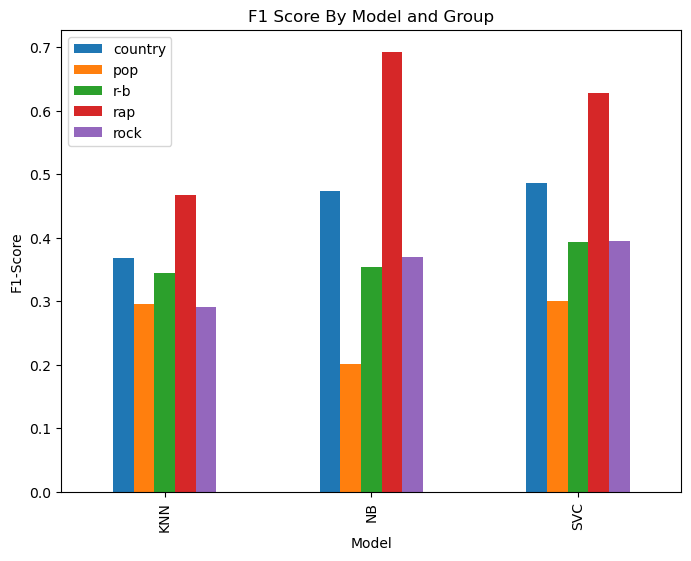

In [ ]:
# Need to flip the df around a little
report_df = report_df[report_df['subset'].isin(label_names)]
report_df_f1 = pd.pivot(report_df, columns='subset', index='model',
                         values='f1-score') # Change values if we want a dif metric
report_df_f1 = report_df_f1.reset_index()

report_df_f1.plot(x= 'model',
                  kind= 'bar',
                  stacked=False,
                  title= 'F1 Score By Model and Group',
                  xlabel="Model",
                  ylabel='F1-Score',
                  figsize=(8,6),
                  ).legend(loc = 'upper left');


# Extracting Probabilities from best model
Currently the best model is looking like the SVC

In [ ]:
# The output is a list of 5 arrays - one array per genre
# Dimensions of array are n songs by 2 (probability of genre being False/True)
svc_prob_predictions = svc_load.predict_proba(X_test)

svc_prob_by_genre = []
for i in range(0, len(svc_prob_predictions)):
    # Take the True probability column from each genre column
    genre_prob = svc_prob_predictions[i][:, 1]
    # Append array of probability being True for each song
    svc_prob_by_genre.append(genre_prob)

# Convert probability predictions to dataframe
svc_prob_df = pd.DataFrame(svc_prob_by_genre).T
svc_prob_df.columns = mlb.classes_.tolist()
svc_prob_df

AttributeError: predict_proba is not available when  probability=False